## Attacking MNIST Dataset

Here we use a custom NN trained on MNIST data to perform *zero order Stochastic Gradient Descent*

**1. Set current directory**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/Colab Notebooks/AdvAttack

/content/gdrive/My Drive/Colab Notebooks/AdvAttack


**2. Import libraries**

In [3]:
import src.loss as customLoss
import src.dataset as data
import src.ZOOptim as ZOOptim

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import math


import torch
from src.models import MnistNet
from torchvision import transforms
from torch import nn, optim

**3. Retrieve MNIST data**

We retrieve the MNIST data. <br>
The 'standard' *trasnform.compose* method just convert the data to *torch.Tensor* without any rescaling or normalizzation


Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([250, 1, 28, 28])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([250])


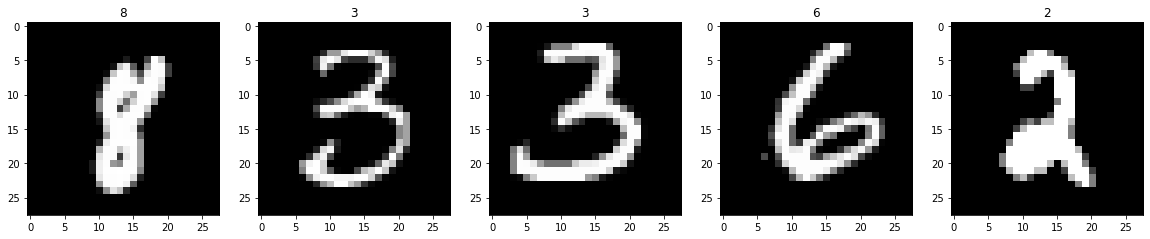

In [4]:
DataLoader = data.MNIST(transform='standard')
train, test = DataLoader.get_dataloader(batch_size=250, num_workers=0)
DataLoader.get_info()

**4. Retrieve the network**

In [5]:
device = torch.device('cuda')
net = MnistNet().to(device)
net.load_state_dict(torch.load('models/mnistBaseV2_state_dict.pth'))

<All keys matched successfully>

### MAIN
**5. ADVERSARIAL ATTACK**

Here we try to start with a random rightfully classified image from the validation set and we try to use *Zero-order Stochastic Coordinate descent with Coordinate-wise ADAM/Newton* to modify the image in order to make the network be mistaken.

We can choose whetever to use ADAM or Newton's Method by setting the solver parameter

**Args:**

        Name            Type                Description
        
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        c:              (float)             Loss weight
        learning_rate:  (float)             Learning rate
        batch_size:     (int)               Coordinates we simultaneously optimize
        h:              (float)             Used in gradient approximation
        beta_1:         (float)             ADAM hyper-parameter
        beta_2:         (float)             ADAM hyper-parameter
        msolver:        (str)               ADAM or Newton
        epsilon:        (float)             Avoid divide by 0
        max_iterations: (int)               The maximum number of steps
        stop_criterion: (bool)              Stop when the loss is zero and the l2 distance doesn't decrease for 20 steps
        verbose:        (int)               Display information or not. Default is 0
        additional_out  (bool)              Return also all the x. Default is False
        tqdm_disable    (bool)              Disable the tqdm bar. Default is False

**Suggested values** <br>
*ZOO: Zeroth Order Optimization Based Black-box Attacks to
Deep Neural Networks without Training Substitute Models* (Chen, Zhang et al.):

* learning_rate = 0.001 
* batch_size = 128
* h = 0.0001
* beta_1 = 0.9
* beta_2 = 0.999
* solver = "adam"
* max_iterations = 10000

All this parameters are initialized by default.



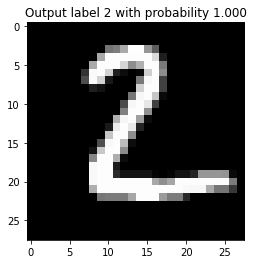

In [6]:
### Get an input used as test
for batch in test:
    X, y = batch[0].to(device), batch[1].to(device)
    break

net.eval()
img_orig = X[1].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[1].reshape(1, 1, 28, 28)))
plt.imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig).item()
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out_orig[0, original_label])))
plt.show()

**5.2 General attack**

Here we try to manipulate the input such that it will be misclassified in favor of a whatever class. Usually its easier and we deal with the problem by minimizing the probability of the true class  

*E.g.* <br> 
We want to try to manimize the probability of classification of neuron *zero*

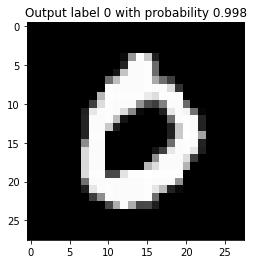

In [7]:
# 1. Choose image
index = 3

# 2. Define params
#solver = "adam"
solver = "newton"

params = {'x': X[index], 'c': 0.5, 'learning_rate': 3e-2, 
          'n_gradient': 128, 'solver': solver, 'max_steps': 10000, 
          'verbose': 0, 'stop_criterion': True, 'additional_out': True}

net.eval()
img_orig = X[index].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[index].reshape(1, 1, 28, 28)))
plt.imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig).item()
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out_orig[0, original_label])))
plt.show()

 20%|█▉        | 1953/10000 [00:18<01:30, 88.78it/s]

First valid image found at iteration 1938 with l2-distance = 1.719381332397461


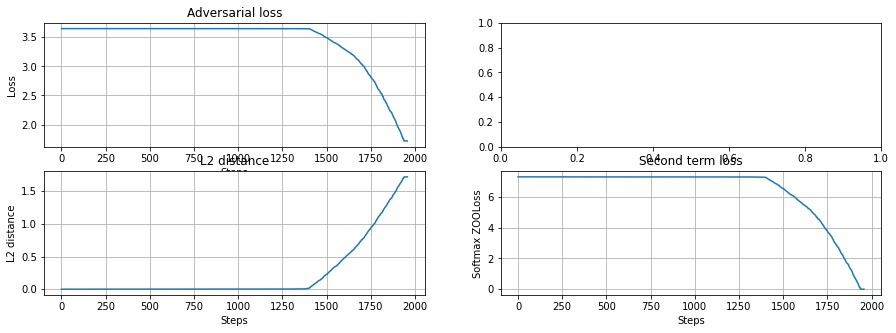

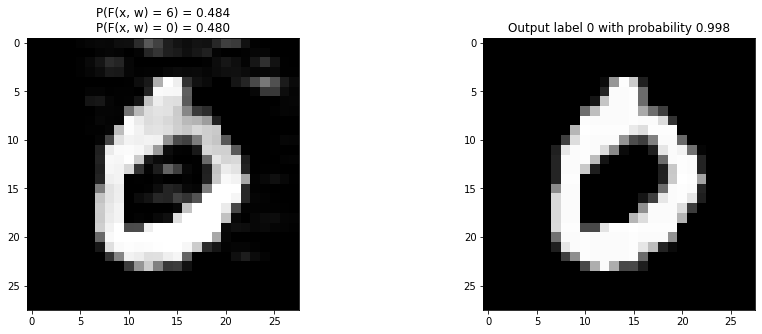

In [8]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=original_label, maximise=0, is_softmax=False, dim=1)
adv_optimizer = ZOOptim.ZOOptim(model=net, loss=adv_loss, device='cuda')

### Run the optimizer
x, loss, l2_dist, losses_st, outs = adv_optimizer.run(**params)


### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, 1, 28, 28)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0,0].plot(loss)
ax[0,0].set_title('Adversarial loss')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_xlabel('Steps')
ax[0,0].grid()
ax[1,0].plot(l2_dist)
ax[1,0].set_title('L2 distance')
ax[1,0].set_ylabel('L2 distance')
ax[1,0].set_xlabel('Steps')
ax[1,0].grid()
ax[1,1].plot(losses_st)
ax[1,1].set_title('Second term loss')
ax[1,1].set_ylabel('Softmax ZOOLoss')
ax[1,1].set_xlabel('Steps')
ax[1,1].grid()
plt.show

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img.reshape(28, 28), cmap='gray')
ax[0].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(label, float(out[0, label]),
                                                                             original_label, float(out[0, original_label])))
ax[1].imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig)
ax[1].set_title('Output label {} with probability {:.3f}'.format(original_label, float(out_orig[0, original_label])))
plt.show()

**5.1 Specific attack**

Here we try to manipulate the input such that it will be misclassified in favor of a *specific* class.

*E.g.* <br> 
We want to try to maximise the probability of classification of neuron *eight*

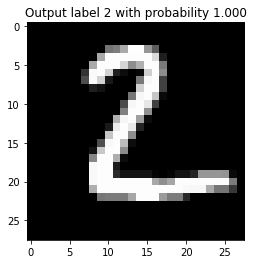

In [9]:
# 1. Choose image
index = 1

# 2. Define params
solver = "adam"
#solver = "newton"

params = {'x': X[index], 'c': 0.3, 'learning_rate': 1e-2, 
          'n_gradient': 128, 'solver': solver, 'max_steps': 10000, 
          'verbose': 0, 'stop_criterion': True, 'additional_out': True}


net.eval()
img_orig = X[index].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[index].reshape(1, 1, 28, 28)))
plt.imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig).item()
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out_orig[0, original_label])))
plt.show()


  2%|▏         | 206/10000 [00:01<01:32, 106.02it/s]

First valid image found at iteration 191 with l2-distance = 2.4070639610290527



  2%|▏         | 217/10000 [00:01<01:37, 99.98it/s] 

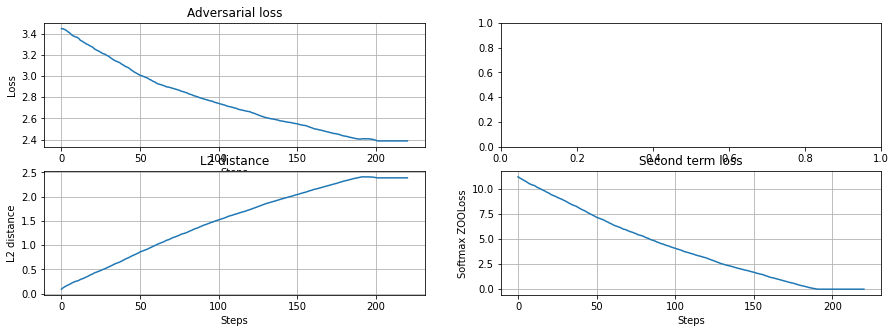

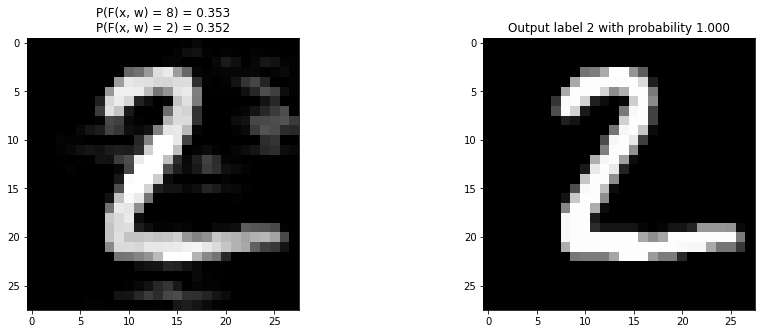

In [10]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=8, maximise=1)
adv_optimizer = ZOOptim.ZOOptim(model=net, loss=adv_loss, device='cuda')
### Run the optimizer
x, loss, l2_dist, losses_st, outs = adv_optimizer.run(**params)

### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, 1, 28, 28)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0,0].plot(loss)
ax[0,0].set_title('Adversarial loss')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_xlabel('Steps')
ax[0,0].grid()
ax[1,0].plot(l2_dist)
ax[1,0].set_title('L2 distance')
ax[1,0].set_ylabel('L2 distance')
ax[1,0].set_xlabel('Steps')
ax[1,0].grid()
ax[1,1].plot(losses_st)
ax[1,1].set_title('Second term loss')
ax[1,1].set_ylabel('Softmax ZOOLoss')
ax[1,1].set_xlabel('Steps')
ax[1,1].grid()
plt.show

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img.reshape(28, 28), cmap='gray')
ax[0].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(label, float(out[0, label]),
                                                                              original_label, float(out[0, original_label])))
ax[1].imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig)
ax[1].set_title('Output label {} with probability {:.3f}'.format(original_label, float(out_orig[0, original_label])))
plt.show()